## Etape 1: récupérez les données et commencez à les regarder 

1. Créez une base sqlite localement
2. Créez deux tables et uploadez les données
3. Récupérez les tables sous forme de dataframe python et faites une exploration rapide de ces données.
4. Quels sont selon vous dans les données patients les données personnelles (identificateurs & quasi-identificateurs) et les données sensibles ?
5. De combien de patients retrouvez vous le nom en faisant une jointure entre ces deux tables ?

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sqlite3
from datetime import date
from dateutil.relativedelta import relativedelta

import numpy as np
import pandas as pd

import pydp as dp  # by convention our package is to be imported as dp (for Differential Privacy!)
from pydp.algorithms.laplacian import BoundedMean, Count

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches



from anonymity.mondrian import MondrianAnonymizer, is_k_anonymous
from anonymity.plot import plot_mondrian

sns.set_style("whitegrid")

1. Créez une base sqlite localement

In [2]:
db_filepath = Path('tp_anonymisation.db')
db_filepath.unlink(missing_ok=True) # rm db if exists

In [3]:
conn = sqlite3.connect(db_filepath)

2. Créez deux tables et uploadez les données

In [4]:
data_dir = Path('../data/')
items_to_feed = [(data_dir / 'personal_data.csv', 'personal_data'),
                 (data_dir / 'sensitive_data.csv', 'sensitive_data')]

for filepath, table_name in items_to_feed:
    pd.read_csv(filepath, sep=';')\
        .to_sql(table_name, conn, if_exists='replace', index=False)

Récupérez les tables sous forme de dataframe python et faites une exploration rapide de ces données.

In [5]:
q = '''
select *
from sensitive_data
'''
df_patients = pd.read_sql(q, conn)

Nombre de patients dans notre fichier de données:

In [6]:
len(df_patients)

1302

In [7]:
df_patients.head()

,nom,prenom,sexe,age,adresse,code_postal,date_naissance,consommation_alcool,activite_physique,tension_arterielle
0,ABADIE,LIONEL,1,57,45 Avenue Edouard Herriot 69150 Décines-Charpieu,69150,1963-12-09,élevée,0,élevée
1,ABALO,MORGANE,2,57,6 Allee des Narcisses 69380 Dommartin,69380,1964-02-07,modérée,1,normale
2,ABDEL GADIR,ANNA,2,63,605 Le Bourg 69430 Vernay,69430,1958-04-16,modérée,1,normale
3,ABDESSALEM,IBRAHIM,1,33,1450 Route du Pont Dorieux 69210 Fleurieux-sur...,69210,1988-01-03,modérée,1,normale
4,ABRANTES DUARTE,MAXIME,1,66,25 Rue de Montribloud 69009 Lyon 9e Arrondisse...,69009,1955-05-31,élevée,0,élevée


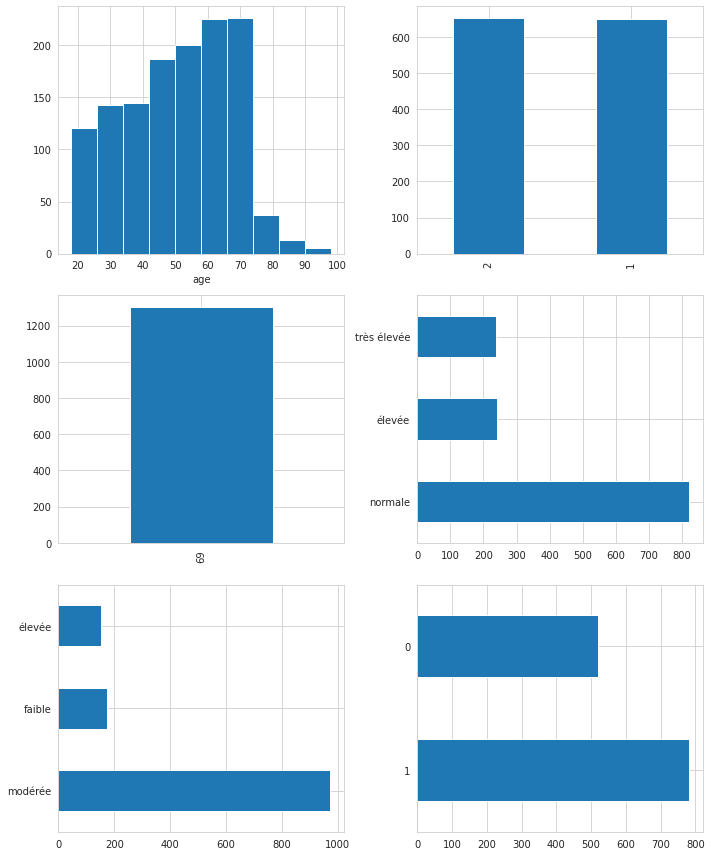

In [8]:
fig, ax = plt.subplots(3, 2, figsize=(10, 12))

# age distribution
ax00 = ax[0, 0]
df_patients['age'].hist(ax=ax00)
ax00.set_xlabel('age')

# sex "ratio"
ax01 = ax[0, 1]
df_patients['sexe'].value_counts().plot(ax=ax01, kind='bar')

# repartition selon le département
ax10 = ax[1, 0]
df_patients['code_postal'].apply(lambda x: str(x)[:2]).value_counts().plot(ax=ax10, kind='bar')

# tension arterielle
ax11 = ax[1, 1]
df_patients['tension_arterielle'].value_counts().plot(ax=ax11, kind='barh')

# tension arterielle
ax21 = ax[2, 0]
df_patients['consommation_alcool'].value_counts().plot(ax=ax21, kind='barh')

# tension arterielle
ax22 = ax[2, 1]
df_patients['activite_physique'].value_counts().plot(ax=ax22, kind='barh')

fig.tight_layout()

In [9]:
q = '''
select *
from personal_data
'''
df_identification = pd.read_sql(q, conn)

Nombre de personnes dans notre fichier de données marketting:

In [10]:
len(df_identification)

100000

In [11]:
df_identification.head()

,nom,prenom,sexe,age,adresse,code_postal
0,BILA,CORINNE,2,60,172 Rue du Pré de l’Eglise 69220 Dracé,69220
1,FRANCOIS,CLAIRE,2,80,35 Avenue des Marronniers 69270 Fontaines-sur-...,69270
2,USTARROZ,YVETTE,2,52,22 Passage de l’Ancienne Mairie 69400 Villefra...,69400
3,FREDET,ANGELIQUE,2,52,47 Avenue du 11 Novembre 1918 69160 Tassin-la-...,69160
4,TEMPLIER,RONAN,1,21,6 Grande Rue 69250 Fleurieu-sur-Saône,69250


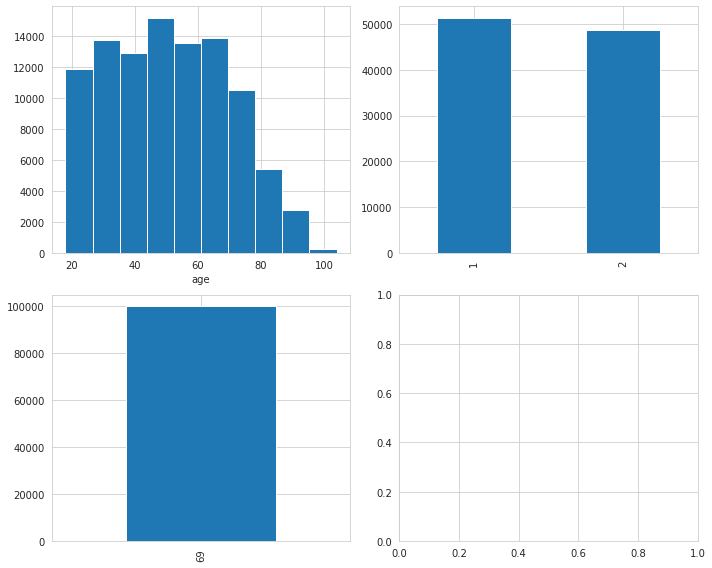

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

# age distribution
ax00 = ax[0, 0]
df_identification['age'].hist(ax=ax00)
ax00.set_xlabel('age')

# sex "ratio"
ax01 = ax[0, 1]
df_identification['sexe'].value_counts().plot(ax=ax01, kind='bar')

# repartition according to department
ax10 = ax[1, 0]
df_identification['code_postal'].apply(lambda x: str(x)[:2]).value_counts().plot(ax=ax10, kind='bar')

fig.tight_layout()

4. Quels sont selon vous dans les données patients les données personnelles (identificateurs & quasi-identificateurs) et les données sensibles ?
5. De combien de patients retrouvez vous le nom en faisant une jointure entre ces deux tables ?

In [13]:
df_naive_join = pd.merge(
    df_identification,
    df_patients,
    on=('nom', 'prenom', 'sexe', 'age', 'adresse', 'code_postal')
)

Nombre de patients de notre fichier de données qui correspondent (nom, prenom, sexe, age, adresse, code_postal) à des personnes issues du fichier de données marketting:

In [14]:
len(df_naive_join)

1002

In [15]:
df_naive_join.head()

,nom,prenom,sexe,age,adresse,code_postal,date_naissance,consommation_alcool,activite_physique,tension_arterielle
0,AUPEE,EMELYNE,2,27,6 Rue Paul-Michel Perret 69006 Lyon 6e Arrondi...,69006,1993-10-09,modérée,1,normale
1,DUBESSET,BRUNO,1,65,10 Allée de la Clé des Champs 69580 Sathonay-V...,69580,1956-08-04,modérée,1,élevée
2,JOUNEAU,SOPHIE,2,49,32 Rue Valentin Couturier 69004 Lyon 4e Arrond...,69004,1972-04-03,modérée,1,normale
3,GARAYT,CLÉMENT,1,69,36 Rue Pierre Brunier 69300 Caluire-et-Cuire,69300,1952-03-09,faible,0,très élevée
4,POLEYA,DANIELLE,2,50,10 Montee du Chatel 69440 Saint-André-la-Côte,69440,1971-06-10,modérée,0,très élevée


Nombre de patients de notre fichier de données qui correspondent  (nom, prenom, sexe, age, adresse, code_postal) à des personnes issues du fichier de données marketting (sans ambiguité):

In [16]:
len(df_naive_join) - df_naive_join.duplicated().sum()

1002

## Etape 2: Pseudonymisez vos données puis attaquez les

1. Supprimer les identificateurs et les remplacer par une valeur unique par patient.
2. Chargez les données pseudonymisées. Combien d'individus vous arrivez à identifier de manière unique et pour combien retrouvez vous le nom et le prénom ?
    * Quelles sont selon vous les limites de la pseudonymisation ?
    * Que feriez vous pour améliorer cette approche ?
3. Mettez en oeuvre vos idées. Pour rappel, dans le cadre de votre étude, il vous faut conserver au minimum sujet des patients:
    * une idée de l'âge
    * le genre
    * une idée de la localisation géographique

1. Supprimer les identificateurs et les remplacer par une valeur unique par patient.

In [17]:
df_patients_pseudo = df_patients.copy()
del df_patients_pseudo['nom']
del df_patients_pseudo['prenom']

In [18]:
df_patients_pseudo.to_sql('sensitive_data_pseudo', conn, if_exists='replace', index=False)

2. Chargez les données pseudonymisées. Combien d'individus vous arrivez à identifier de manière unique et pour combien retrouvez vous le nom et le prénom ?
    * Quelles sont selon vous les limites de la pseudonymisation ?
    * Que feriez vous pour améliorer cette approche ?

In [19]:
q = '''
select *
from sensitive_data_pseudo 
group by age, sexe, adresse
having count(*) == 1
'''

n_pseudo_unique = pd.read_sql(q, conn).shape[0]

In [20]:
n_pseudo_unique

1300

In [21]:
q = '''
with all_matches as (
select pdata.nom,
       pdata.prenom,
       sdata.*
from sensitive_data_pseudo as sdata
inner join personal_data as pdata
on pdata.age = sdata.age and pdata.adresse = sdata.adresse and pdata.sexe = sdata.sexe
)
select *
from all_matches
group by age, adresse, sexe
having count(*) == 1
'''
df_pseudo_identified = pd.read_sql(q, conn)

Nombre de patients de notre fichier de données pseudonymisé qui correspondent (nom, prenom, adresse) à des personnes issues du fichier de données marketting (sans ambiguité):

In [22]:
len(df_pseudo_identified)

994

In [23]:
q = '''
with all_matches as (
select pdata.nom,
       pdata.prenom,
       sdata.*
from sensitive_data_pseudo as sdata
inner join personal_data as pdata
on pdata.age = sdata.age and pdata.adresse = sdata.adresse and pdata.sexe = sdata.sexe
),

ambiguous as (
select age, adresse, sexe
from all_matches
group by age, adresse, sexe
having count(*) > 1
)
select personal_data.*
from personal_data
join ambiguous
on personal_data.age = ambiguous.age and personal_data.sexe = ambiguous.sexe and personal_data.adresse = ambiguous.adresse
'''
df_pseudo_unidentified = pd.read_sql(q, conn)

In [24]:
df_pseudo_unidentified.sort_values(['sexe', 'age', 'adresse'])

,nom,prenom,sexe,age,adresse,code_postal
3,CHAPUIS,EMMANUEL,1,26,11 Chemin du Saquin 69130 Écully,69130
4,MORIN,ANTHONY,1,26,11 Chemin du Saquin 69130 Écully,69130
0,COSTE,ALI,1,55,74 Boulevard des Tchécoslovaques 69007 Lyon 7e...,69007
5,POITTE,NICOLAS,1,55,74 Boulevard des Tchécoslovaques 69007 Lyon 7e...,69007
1,BULTS,ISABELLE,2,25,1 Place Louis Grenier 69320 Feyzin,69320
11,JAISSON,MARIELLE,2,25,1 Place Louis Grenier 69320 Feyzin,69320
2,FLOCH,MATHILDE,2,39,4 Rue Fournet 69006 Lyon 6e Arrondissement,69006
10,ESPOSITO,IVANNA,2,39,4 Rue Fournet 69006 Lyon 6e Arrondissement,69006
6,MARIAMA,BELLA,2,40,84 Rue du Dauphiné 69003 Lyon 3e Arrondissement,69003
9,PERRIN,LYLA,2,40,84 Rue du Dauphiné 69003 Lyon 3e Arrondissement,69003


3. Mettez en oeuvre vos idées. Pour rappel, dans le cadre de votre étude, il vous faut conserver au minimum sujet des patients:
    * une idée de l'âge
    * le genre
    * une idée de la localisation géographique

In [25]:
df_patients_anonym_naive = pd.read_sql('select * from sensitive_data_pseudo', conn)
s_age = df_patients_anonym_naive['age']
df_patients_anonym_naive['age_cut'] = pd.cut(s_age, range(0, 110, 10))
del df_patients_anonym_naive['date_naissance']
del df_patients_anonym_naive['adresse']
del df_patients_anonym_naive['age']

In [26]:
df_patients_anonym_naive.head()

,sexe,code_postal,consommation_alcool,activite_physique,tension_arterielle,age_cut
0,1,69150,élevée,0,élevée,"(50, 60]"
1,2,69380,modérée,1,normale,"(50, 60]"
2,2,69430,modérée,1,normale,"(60, 70]"
3,1,69210,modérée,1,normale,"(30, 40]"
4,1,69009,élevée,0,élevée,"(60, 70]"


In [27]:
df_identification_anonym_naive = pd.read_sql('select * from personal_data', conn)
s_age = df_identification_anonym_naive['age']
df_identification_anonym_naive['age_cut'] = pd.cut(s_age, range(0, 110, 10))

In [28]:
mask = df_patients_anonym_naive.duplicated(['age_cut', 'code_postal', 'sexe'], keep=False)
df_patients_anonym_naive_identifiable = df_patients_anonym_naive[~mask]

Nombre de patients réidentifiables (identifiés de manière unique dans les données de santé) à partir de l'age (discretisé) du code postal et du sexe:

In [29]:
len(df_patients_anonym_naive)

1302

In [30]:
df_merge = pd.merge(df_patients_anonym_naive,
                    df_identification_anonym_naive,
                    on=('age_cut', 'code_postal', 'sexe'),
                    how='inner')

Nombre de patients réidentifiés à partir de l'age (discretisé) du code postal et du sexe:

<AxesSubplot:>

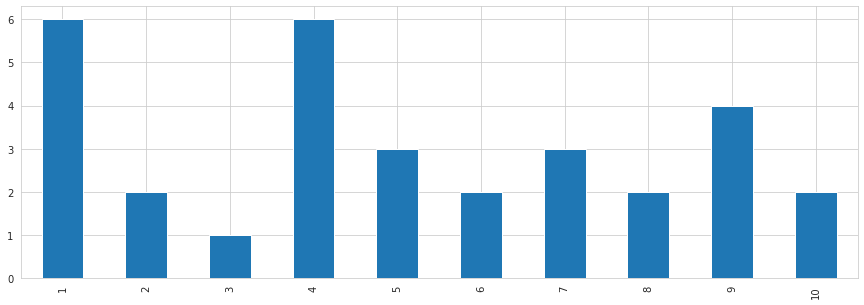

In [31]:
fig, ax = plt.subplots(figsize=(15, 5))
s = df_merge.groupby(['age_cut', 'code_postal', 'sexe']).size()
s[(s>0) & (s <=10)].value_counts().sort_index().plot(kind='bar', ax=ax)

In [32]:
df_merge_identified = df_merge[~df_merge.duplicated(['age_cut', 'code_postal', 'sexe'], keep=False)]

In [33]:
df_merge_identified

,sexe,code_postal,consommation_alcool,activite_physique,tension_arterielle,age_cut,nom,prenom,age,adresse
103088,1,69115,modérée,1,élevée,"(30, 40]",CHRIST,FLAVIO,40,797 Route de Chiroubles 69115 Chiroubles
123127,1,69115,faible,1,normale,"(50, 60]",DEMOULIN,JULIEN,57,125 Route du Col du Truges 69115 Chiroubles
123128,2,69115,modérée,1,très élevée,"(70, 80]",DEMOULIN,LILOU,74,580 Route de la Gravelle 69115 Chiroubles
127196,2,69115,modérée,0,normale,"(30, 40]",DOMINGUES,BRUNE,33,200 Route des Bonnes 69115 Chiroubles
167700,1,69115,élevée,1,normale,"(10, 20]",LAMANDE,QUENTIN,20,124 Rue de la Bascule 69115 Chiroubles
180810,2,69115,modérée,0,très élevée,"(40, 50]",POURRE,LYSA,47,124 Rue de la Forge 69115 Chiroubles


## Anonymisation

1. Déterminez le paramètre K associé à votre anonymisation
2. Décrivez sur papier un algorithme simple pour automatiser la procédure de K-anonymisation (vous pouvez l'implémenter en bonus)
3. 5-anonymisez ces données (manuellement, à partir du package anonymity [(doc)](https://abel-betraoui.github.io/tp-insa-anonymity/anonymity.html#module-anonymity) ou de votre propre implémentation)
4. En vous servant des différentes limites de la K-anonymisation, tâchez de retrouver le plus d'informations possibles sur les patients du jeu de données K-anonymisé

1. Déterminez le paramètre K associé à votre anonymisation

In [34]:
s = df_patients_anonym_naive.groupby(['sexe', 'code_postal', 'age_cut']).size()
s[s>0].min()

1

2. Décrivez sur papier un algorithme simple pour automatiser la procédure de K-anonymisation (vous pouvez l'implémenter en bonus)

<img src="images/pseudocode.png" width="300" alt="pseudocode">

K. LeFevre, D. J. DeWitt and R. Ramakrishnan, "Mondrian Multidimensional K-Anonymity," 22nd International Conference on Data Engineering (ICDE'06), 2006, pp. 25-25, doi: 10.1109/ICDE.2006.101.

3. 5-anonymisez ces données (manuellement ou pensez à un algorithme simple pour le faire)

In [35]:
df_patients_anonym = df_patients.copy()
del df_patients_anonym['nom']
del df_patients_anonym['prenom']
del df_patients_anonym['adresse']

In [36]:
d_metadata = {'age': {},
 'code_postal': {},
 'sexe': {'prevent_generalization': True},
 'activite_physique': {'is_sensitive': True},
 'consommation_alcool': {'is_sensitive': True},
 'tension_arterielle': {'is_sensitive': True}}

In [37]:
anonymizer = MondrianAnonymizer(k=5)
df_anonymized = anonymizer.anonymize(df_patients_anonym, d_metadata)

In [38]:
df_anonymized.head()

,age,code_postal,sexe,activite_physique,consommation_alcool,tension_arterielle
0,38-67,69140-69150,1,0,élevée,élevée
1,57-90,69380,2,1,modérée,normale
2,61-63,69430-69440,2,1,modérée,normale
3,25-64,69210-69220,1,1,modérée,normale
4,31-83,69009,1,0,élevée,élevée


In [39]:
df_anomymized_h = df_anonymized.query('sexe == 1')
df_anomymized_f = df_anonymized.query('sexe == 2')

In [40]:
df_anomymized_h.groupby(['sexe', 'code_postal', 'age']).size().to_frame().rename(columns={0: 'size'}).min()

size    5
dtype: int64

In [41]:
df_anomymized_f.groupby(['sexe', 'code_postal', 'age']).size().to_frame().rename(columns={0: 'size'}).min()

size    5
dtype: int64

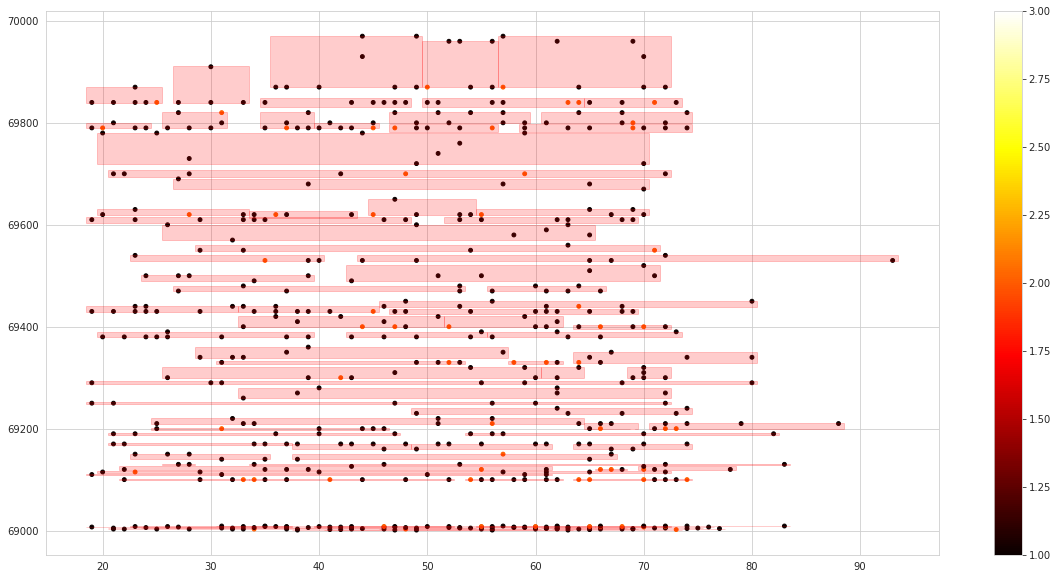

In [42]:
plot_mondrian(df_patients_anonym.query('sexe == 1'), df_anomymized_h)

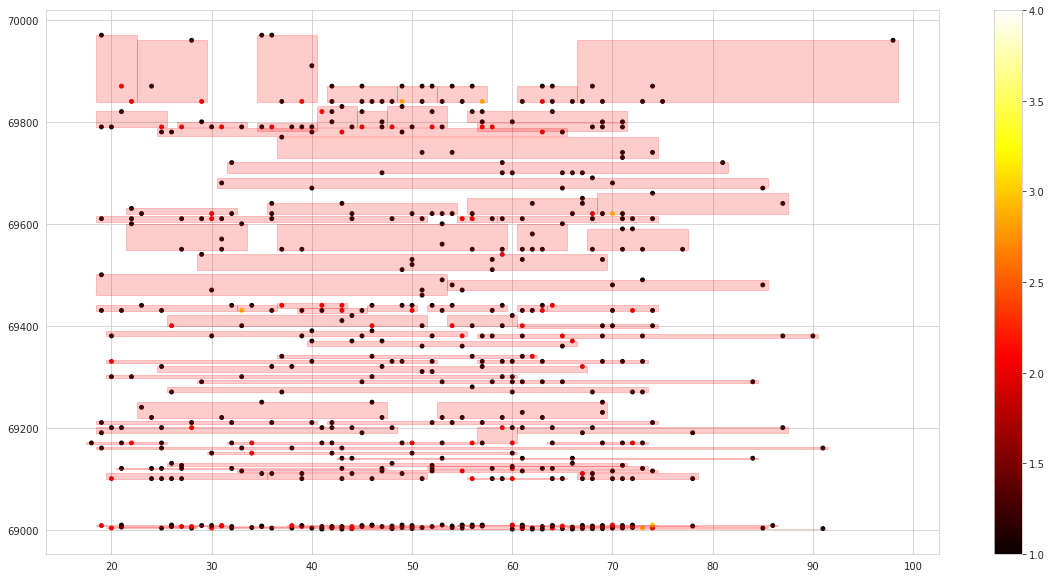

In [43]:
plot_mondrian(df_patients_anonym.query('sexe == 2'), df_anomymized_f)

4. En vous servant des différentes limites de la K-anonymisation, tâchez de retrouver le plus d'informations possibles sur les patients du jeu de données K-anonymisé (*scenario du journaliste*)

In [44]:
def dummify_cols(df, cols):
    df_dummies = pd.get_dummies(df[cols])
    df_dummies.rename(columns={"activite_physique": "activite_physique_suffisante"}, inplace=True)
    df_dummies['activite_physique_insuffisante'] = 1 - df_dummies.activite_physique_suffisante

    dummy_cols = df_dummies.columns
    df_hm = pd.concat(
        [df[['sexe', 'code_postal', 'age']],
         df_dummies],
         axis=1)
    return df_hm.groupby(['sexe', 'code_postal', 'age'])[dummy_cols].mean()

<AxesSubplot:ylabel='sexe-code_postal-age'>

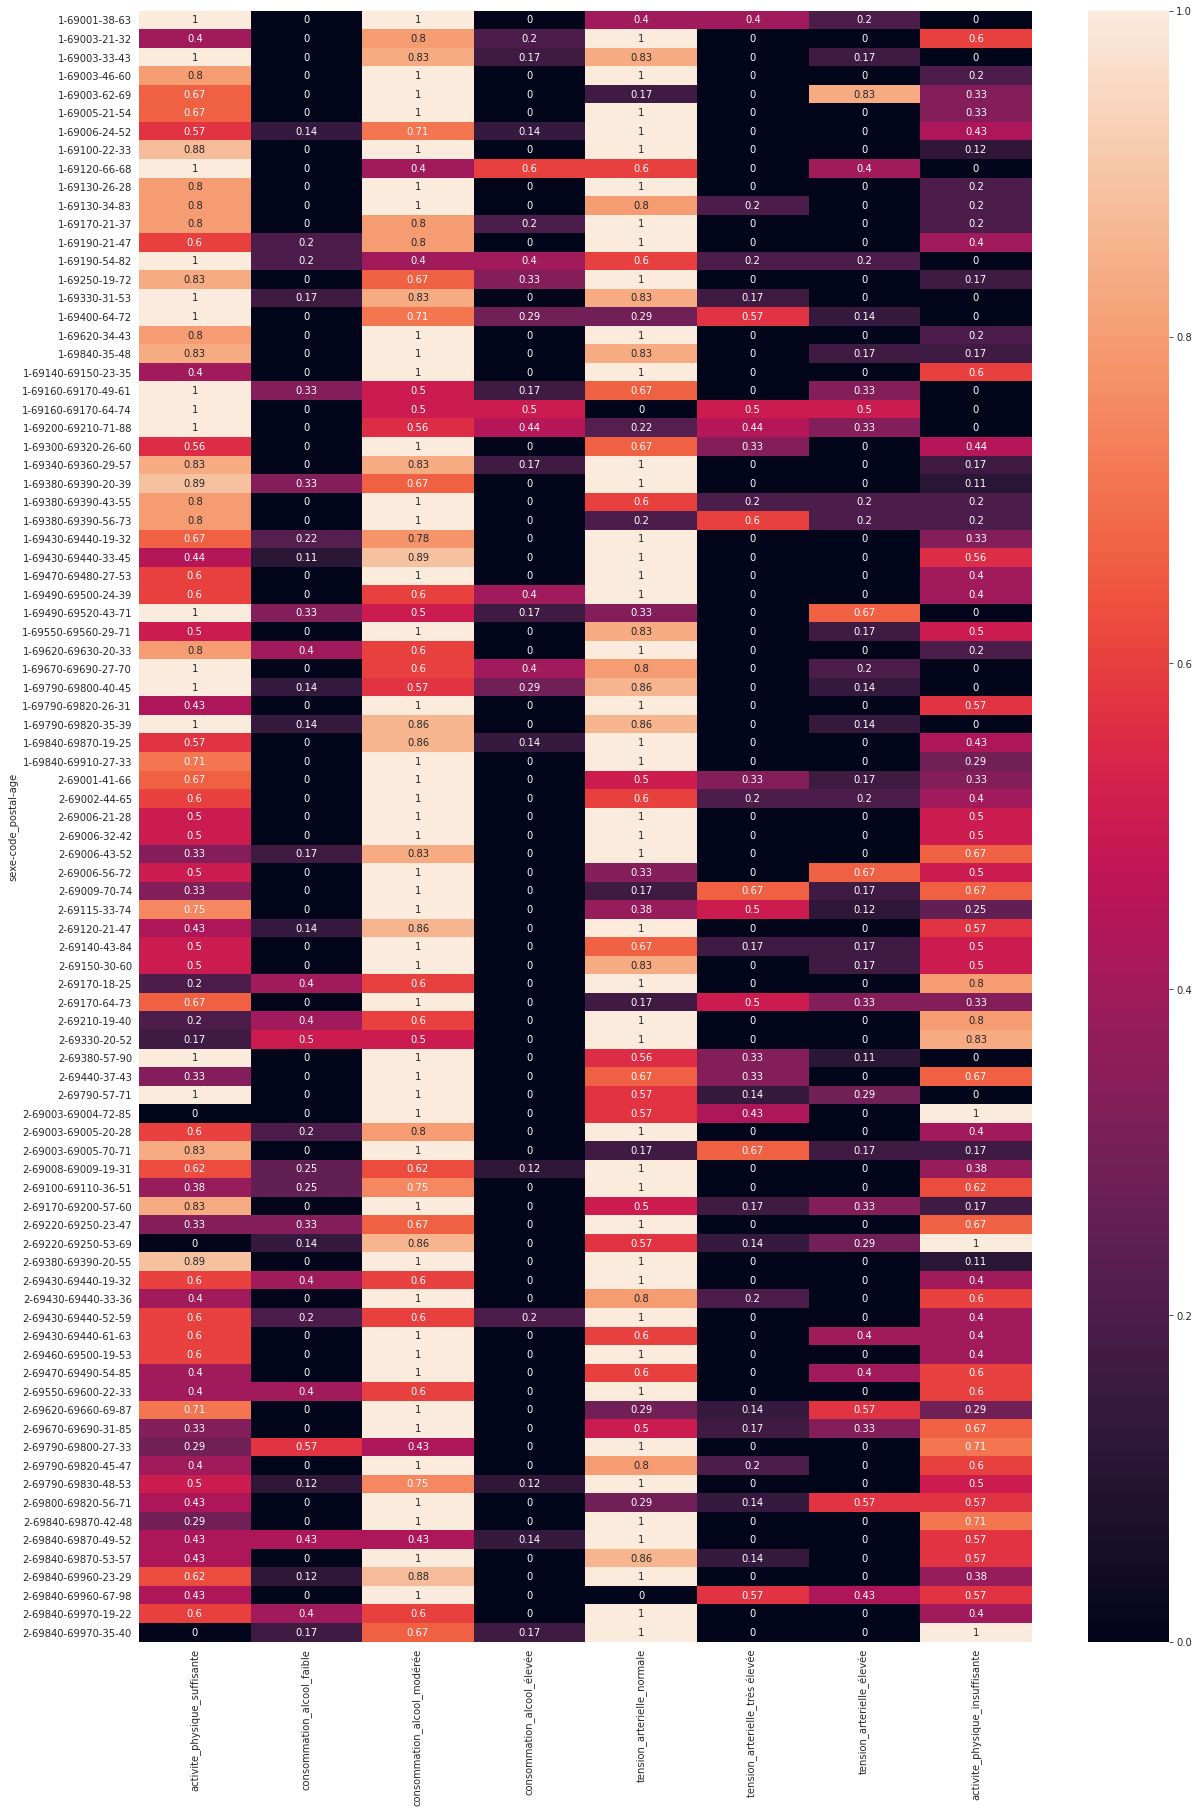

In [45]:
df_hm = dummify_cols(df_anonymized, anonymizer.sensitive)
fig, ax = plt.subplots(figsize=(20, 30))
sns.heatmap(df_hm[(df_hm == 1).any(axis=1)], ax=ax, annot=True)

5. Que pouvez vous dire en particulier des patients suivants en ne vous servant que du jeu de données K-anonymisé (*scenario du procureur*)? 

| nom       | prenom   |   age |   sexe |   code_postal |
|:----------|:---------|------:|-------:|--------------:|
| LEMERLE   | NELLIE   |    19 |      2 |         69430 |
| KEHYRIAN  | ELODIE   |    20 |      2 |         69100 |
| RAYNAL    | MARINA   |    70 |      2 |         69620 |
| GLOTIN    | SIMON    |    72 |      1 |         69200 |
| HASCOET   | MARION   |    57 |      2 |         69840 |
| GUILLAUME | CHANTAL  |    68 |      2 |         69003 |

In [46]:
filepath_patients_to_find = data_dir / 'patients_to_find.csv'
df_patients_to_find = pd.read_csv(filepath_patients_to_find, sep=';')
l_patients = [s for _, s in df_patients_to_find.iterrows()]

display(df_patients_to_find)

for d_patient in l_patients:
    display(anonymizer.get_individual(df_anonymized, pd.Series(d_patient)))

,nom,prenom,age,sexe,code_postal
0,LEMERLE,NELLIE,19,2,69430
1,KEHYRIAN,ELODIE,20,2,69100
2,RAYNAL,MARINA,70,2,69620
3,GLOTIN,SIMON,72,1,69200
4,HASCOET,MARION,57,2,69840
5,GUILLAUME,CHANTAL,68,2,69003


These features were not used to fetch the individual: {'prenom', 'nom'}


,age,code_postal,sexe,activite_physique,consommation_alcool,tension_arterielle
285,19-32,69430-69440,2,1,faible,normale
461,19-32,69430-69440,2,1,modérée,normale
682,19-32,69430-69440,2,0,modérée,normale
771,19-32,69430-69440,2,0,modérée,normale
1282,19-32,69430-69440,2,1,faible,normale


These features were not used to fetch the individual: {'prenom', 'nom'}


,age,code_postal,sexe,activite_physique,consommation_alcool,tension_arterielle
54,20-35,69100-69110,2,1,modérée,élevée
160,20-35,69100-69110,2,0,faible,normale
304,20-35,69100-69110,2,0,modérée,normale
578,20-35,69100-69110,2,1,modérée,normale
672,20-35,69100-69110,2,0,faible,normale
1169,20-35,69100-69110,2,1,faible,normale
1210,20-35,69100-69110,2,1,faible,normale


These features were not used to fetch the individual: {'prenom', 'nom'}


,age,code_postal,sexe,activite_physique,consommation_alcool,tension_arterielle
493,69-87,69620-69660,2,1,modérée,normale
528,69-87,69620-69660,2,1,modérée,élevée
726,69-87,69620-69660,2,0,modérée,normale
809,69-87,69620-69660,2,1,modérée,élevée
1060,69-87,69620-69660,2,1,modérée,élevée
1079,69-87,69620-69660,2,1,modérée,très élevée
1100,69-87,69620-69660,2,0,modérée,élevée


These features were not used to fetch the individual: {'prenom', 'nom'}


,age,code_postal,sexe,activite_physique,consommation_alcool,tension_arterielle
256,71-88,69200-69210,1,1,modérée,élevée
390,71-88,69200-69210,1,1,élevée,élevée
542,71-88,69200-69210,1,1,modérée,normale
599,71-88,69200-69210,1,1,élevée,très élevée
641,71-88,69200-69210,1,1,modérée,très élevée
942,71-88,69200-69210,1,1,modérée,élevée
1183,71-88,69200-69210,1,1,élevée,normale
1227,71-88,69200-69210,1,1,modérée,très élevée
1263,71-88,69200-69210,1,1,élevée,très élevée


These features were not used to fetch the individual: {'prenom', 'nom'}


,age,code_postal,sexe,activite_physique,consommation_alcool,tension_arterielle
288,53-57,69840-69870,2,0,modérée,normale
434,53-57,69840-69870,2,0,modérée,normale
526,53-57,69840-69870,2,1,modérée,normale
591,53-57,69840-69870,2,1,modérée,très élevée
913,53-57,69840-69870,2,0,modérée,normale
929,53-57,69840-69870,2,0,modérée,normale
992,53-57,69840-69870,2,1,modérée,normale


These features were not used to fetch the individual: {'prenom', 'nom'}


,age,code_postal,sexe,activite_physique,consommation_alcool,tension_arterielle
458,66-69,69003-69005,2,1,modérée,très élevée
571,66-69,69003-69005,2,1,faible,très élevée
831,66-69,69003-69005,2,1,modérée,très élevée
932,66-69,69003-69005,2,0,modérée,très élevée
1104,66-69,69003-69005,2,0,modérée,très élevée
1207,66-69,69003-69005,2,0,faible,normale


6. Pouvez-vous répondre à ces questions ?
    * Combien de patients ont participé à l'étude ?
    * Combien de patients ont une tension artérielle très élevée ?
    * Parmi les patients de 60 ans et plus avec une consommation élevée d'alcool, quel pourcentage a
    une tension artérielle très élevée ?
    * Quel est le taux de tension artérielle "très élevée" à Villeurbanne (69100)?
    

Combien de patients ont participé à l'étude ?

In [47]:
len(df_anonymized)

1302

Combien de patients ont une tension artérielle très élevée ?

In [48]:
len(df_anonymized.query('tension_arterielle == "très élevée"'))

239

Parmi les patients de 60 ans et plus avec une consommation élevée d'alcool, quel pourcentage à une tension artérielle très élevée ?

In [49]:
df_anonymized

,age,code_postal,sexe,activite_physique,consommation_alcool,tension_arterielle
0,38-67,69140-69150,1,0,élevée,élevée
1,57-90,69380,2,1,modérée,normale
2,61-63,69430-69440,2,1,modérée,normale
3,25-64,69210-69220,1,1,modérée,normale
4,31-83,69009,1,0,élevée,élevée
...,...,...,...,...,...,...
1297,69-72,69300-69320,1,0,faible,élevée
1298,19-48,69190-69200,2,0,faible,normale
1299,31-83,69009,1,1,modérée,élevée
1300,30-40,69003-69004,2,1,faible,normale


Impossible de répondre, les patients de 60 ans et plus ont été regroupés avec des patients de classe d'âges différentes.

In [50]:
anonymizer.get_individual(df_anonymized, pd.Series({'age': 61}))

,age,code_postal,sexe,activite_physique,consommation_alcool,tension_arterielle
0,38-67,69140-69150,1,0,élevée,élevée
1,57-90,69380,2,1,modérée,normale
2,61-63,69430-69440,2,1,modérée,normale
3,25-64,69210-69220,1,1,modérée,normale
4,31-83,69009,1,0,élevée,élevée
...,...,...,...,...,...,...
1290,56-65,69100,2,0,modérée,normale
1291,22-61,69120-69126,1,0,élevée,normale
1292,50-64,69840,1,0,élevée,normale
1295,19-72,69250,1,1,modérée,normale


Impossible de répondre, les patients de Villeurbanne ont été regroupés avec des patients d'autres communes.

In [51]:
anonymizer.get_individual(df_anonymized, pd.Series({'code_postal': 69100}))

,age,code_postal,sexe,activite_physique,consommation_alcool,tension_arterielle
40,36-51,69100-69110,2,1,modérée,normale
54,20-35,69100-69110,2,1,modérée,élevée
69,64-74,69100,1,1,modérée,élevée
78,22-33,69100,1,1,modérée,normale
91,22-33,69100,1,1,modérée,normale
...,...,...,...,...,...,...
1234,67-78,69100-69110,2,0,modérée,élevée
1274,22-33,69100,1,1,modérée,normale
1290,56-65,69100,2,0,modérée,normale
1293,67-78,69100-69110,2,1,modérée,élevée


## L-diversité

1. Utilisez le package anonymity pour comparer les comportements de la K-anonymisation et de la L-diversité. Qu'apporte la L-diversité, à quel(s) coût(s) ?

In [52]:
anonymizer_kl = MondrianAnonymizer(k=5, l=2)
df_anonymized_kl = anonymizer_kl.anonymize(df_patients_anonym, d_metadata)
df_anonymized_kl_h = df_anonymized_kl.query('sexe == 1')
df_anonymized_kl_f = df_anonymized_kl.query('sexe == 2')

<AxesSubplot:ylabel='sexe-code_postal-age'>

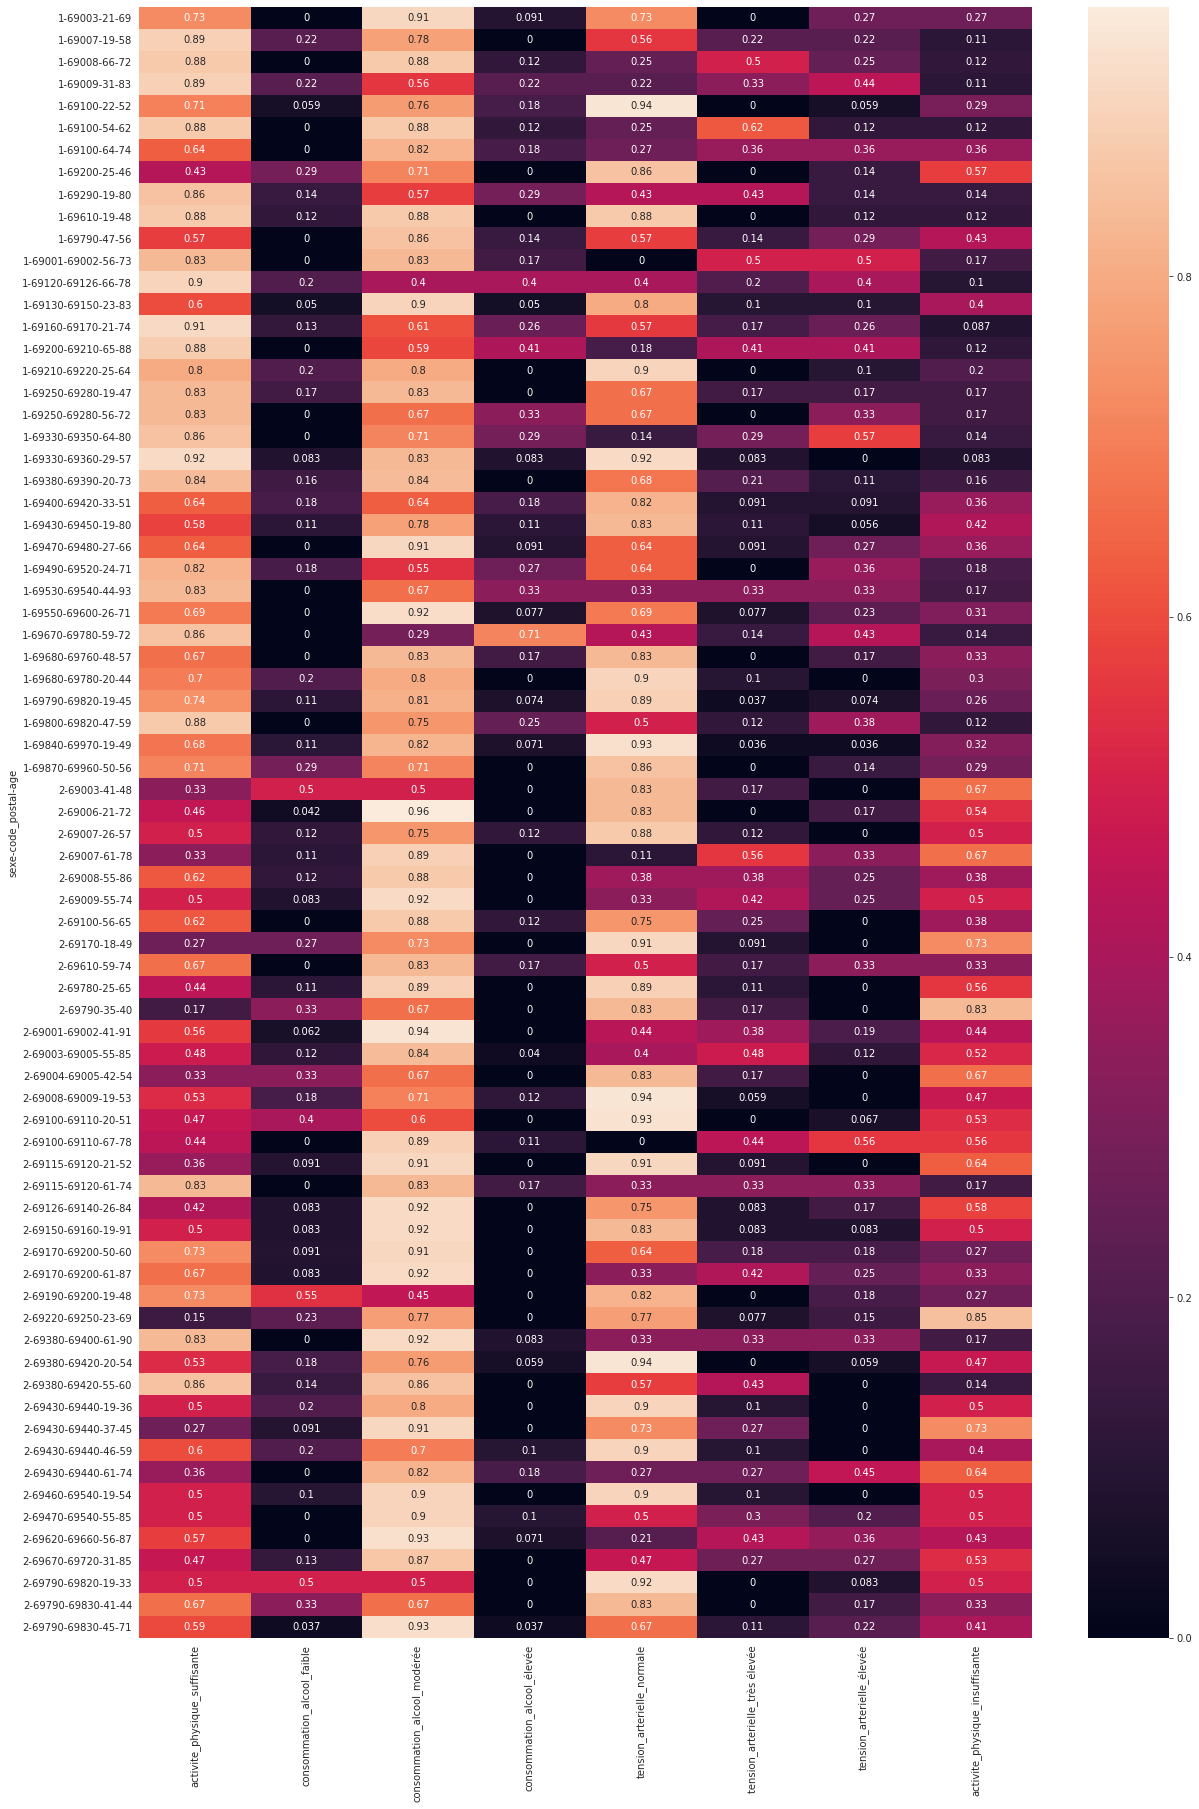

In [53]:
df_hm = dummify_cols(df_anonymized_kl, anonymizer_kl.sensitive)
fig, ax = plt.subplots(figsize=(20, 30))
sns.heatmap(df_hm[(df_hm > .8).any(axis=1)], ax=ax, annot=True)

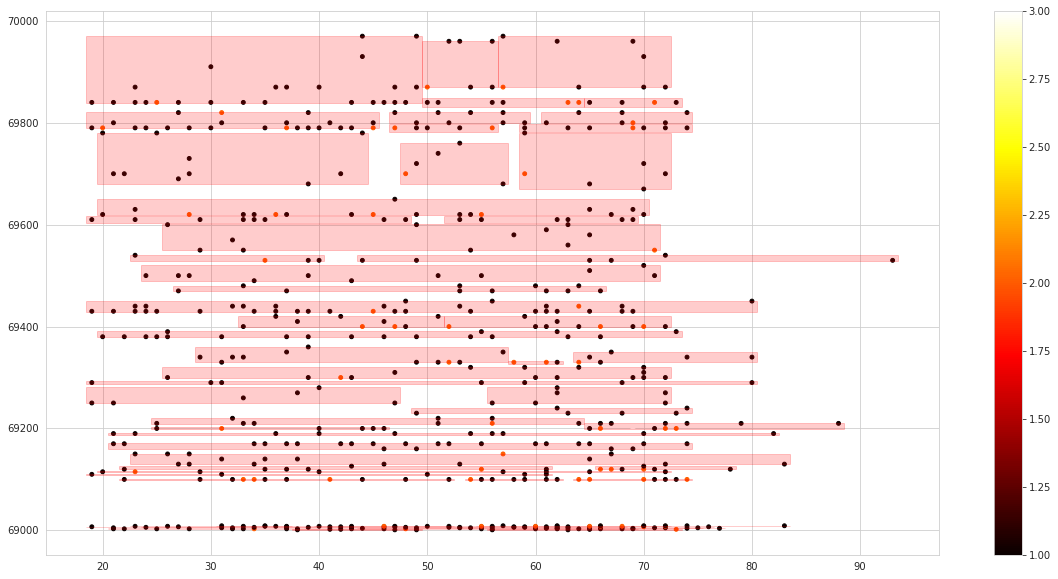

In [54]:
plot_mondrian(df_patients_anonym.query('sexe == 1'), df_anonymized_kl_h)

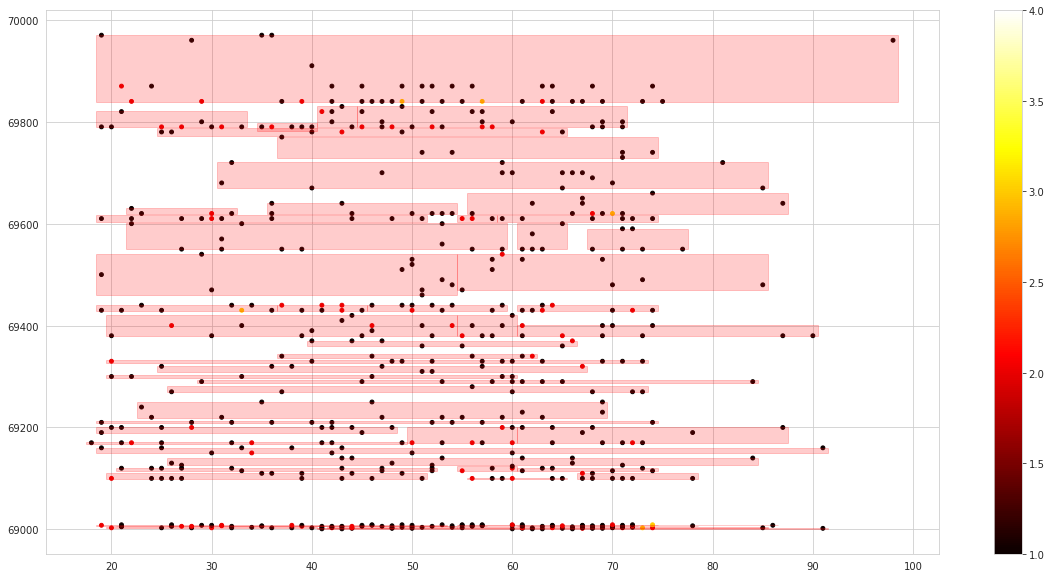

In [55]:
plot_mondrian(df_patients_anonym.query('sexe == 2'), df_anonymized_kl_f)

## Etape 4 - Créer le doute:  la confidentialité différentielle

* En vous inspirant de [ce notebook](https://github.com/OpenMined/PyDP/blob/dev/examples/Tutorial_3-Titanic_demo/titanic_notebook.ipynb), répondez aux questions suivantes et comparez les résultats obtenus **avec ou sans** confidentialité différentielle [(doc)](https://pydp.readthedocs.io/en/latest/pydp.html) ?
    * Combien de patients ont participé à l'étude ?
    * Combien de patients ont une tension artérielle très élevée ?
    * Parmi les patients de 60 ans et plus avec une consommation élevée d'alcool, quel pourcentage a une tension artérielle très élevée ?
    * Quel est le taux de tension artérielle "très élevée" à Villeurbanne (69100)?
    
* Utilisez la fonction result au lieu de quick result. 
    * Quelle est l'influence de epsilon sur le résultat final ?
    * Que se passe t-il lorsque le privacy budget est consommé ?
    * Pourquoi selon vous ?

Combien de patients ont participé à l'étude ?

In [56]:
len(df_patients)

1302

In [57]:
privacy_budget = 1
count = Count(privacy_budget, dtype="float")
count.quick_result(df_patients.index)

1301

In [58]:
privacy_budget = 1
count = Count(privacy_budget, dtype="float")
count.add_entries(df_patients.index)
print(count.privacy_budget_left())
print(count.result(1))
print(count.privacy_budget_left())
print(count.result(1))

1.0
1302
0.0


RuntimeError: Privacy Budget left is already 0, you can't do any more operations

* Utilisez la fonction result au lieu de quick result. 
    * Quelle est l'influence de epsilon sur le résultat final ? *Plus epsilon est faible plus on se rapproche de la perfect privacy. C'est à dire que le risque est nul, les données obtenues sont par contre inexploitables.*
    * Que se passe t-il lorsque le privacy budget est consommé ? *On ne peut plus faire de requêtes.*
    * Pourquoi selon vous ? *Cela permet de limiter le risque de differential attacks*

Combien de patients ont une tension artérielle très élevée ?

In [59]:
mask = (df_patients.tension_arterielle == 'très élevée')
mask.sum()

239

In [60]:
privacy_budget = 1
count = Count(privacy_budget, dtype="float")
count.quick_result(df_patients.index[mask])

240

Parmi les patients de 60 ans et plus avec une consommation élevée d'alcool, quel pourcentage à une tension artérielle très élevée ?

In [61]:
dfx =  df_patients[(df_patients['consommation_alcool'] == 'élevée') & (df_patients.age >= 60)]
s = (dfx.tension_arterielle == 'très élevée').astype(int)
s.mean()

0.3333333333333333

In [62]:
privacy_budget = 1
mean = BoundedMean(privacy_budget, lower_bound=0, upper_bound=1, dtype="float")
mean.quick_result(s.tolist())

0.33804159395960576

Les patients de villeurbanne ont ils un taux de tension artérielle très élevée plus grand que dans les autres communes?

In [63]:
dfx = df_patients[(df_patients['code_postal'] == 69100)]
s = (dfx.tension_arterielle == 'très élevée').astype(int)
s.mean()

0.21666666666666667

In [64]:
privacy_budget = 1
mean = BoundedMean(privacy_budget, lower_bound=0, upper_bound=1, dtype="float")

mean.quick_result(s.tolist())

0.15364797339896846